# **Chapter 21. Recommender Systems**

In [ ]:
#@title

import requests

url = 'https://raw.githubusercontent.com/joelgrus/data-science-from-scratch/master/scratch/linear_algebra.py'
r = requests.get(url)

with open('linear_algebra.py', 'w') as f:
    f.write(r.text)

from linear_algebra import Vector, dot, add, subtract, magnitude, squared_distance, scalar_multiply

url = 'https://raw.githubusercontent.com/joelgrus/data-science-from-scratch/master/scratch/probability.py'
r = requests.get(url)

with open('probability.py', 'w') as f:
    f.write(r.text)

import math

from probability import inverse_normal_cdf

def gradient_step(v: Vector, gradient: Vector, step_size: float) -> Vector:
    """Moves `step_size` in the `gradient` direction from `v`"""
    assert len(v) == len(gradient)
    step = scalar_multiply(step_size, gradient)
    return add(v, step)
    
def error(x: Vector, y: float, beta: Vector) -> float:
    return predict(x, beta) - y

def squared_error(x: Vector, y: float, beta: Vector) -> float:
    return error(x, y, beta) ** 2

def sqerror_gradient(x: Vector, y: float, beta: Vector) -> Vector:
    err = error(x, y, beta)
    return [2 * err * x_i for x_i in x]

###########

def cosine_similarity(v1: Vector, v2: Vector) -> float:
    return dot(v1, v2) / math.sqrt(dot(v1, v1) * dot(v2, v2))

Tensor = list
from typing import List

import random

def random_uniform(*dims: int) -> Tensor:
    if len(dims) == 1:
        return [random.random() for _ in range(dims[0])]
    else:
        return [random_uniform(*dims[1:]) for _ in range(dims[0])]

def random_normal(*dims: int,
                  mean: float = 0.0,
                  variance: float = 1.0) -> Tensor:
    if len(dims) == 1:
        return [mean + variance * inverse_normal_cdf(random.random())
                for _ in range(dims[0])]
    else:
        return [random_normal(*dims[1:], mean=mean, variance=variance)
                for _ in range(dims[0])]

def random_tensor(*dims: int, init: str = 'normal') -> Tensor:
    if init == 'normal':
        return random_normal(*dims)
    elif init == 'uniform':
        return random_uniform(*dims)
    elif init == 'xavier':
        variance = len(dims) / sum(dims)
        return random_normal(*dims, variance=variance)
    else:
        raise ValueError(f"unknown init: {init}")

##############

def de_mean(data: List[Vector]) -> List[Vector]:
    """Recenters the data to have mean 0 in every dimension"""
    mean = vector_mean(data)
    return [subtract(vector, mean) for vector in data]

def direction(w: Vector) -> Vector:
    mag = magnitude(w)
    return [w_i / mag for w_i in w]

def directional_variance(data: List[Vector], w: Vector) -> float:
    """
    Returns the variance of x in the direction of w
    """
    w_dir = direction(w)
    return sum(dot(v, w_dir) ** 2 for v in data)

def directional_variance_gradient(data: List[Vector], w: Vector) -> Vector:
    """
    The gradient of directional variance with respect to w
    """
    w_dir = direction(w)
    return [sum(2 * dot(v, w_dir) * v[i] for v in data)
            for i in range(len(w))]

def first_principal_component(data: List[Vector],
                              n: int = 100,
                              step_size: float = 0.1) -> Vector:
    # Start with a random guess
    guess = [1.0 for _ in data[0]]

    with tqdm.trange(n) as t:
        for _ in t:
            dv = directional_variance(data, guess)
            gradient = directional_variance_gradient(data, guess)
            guess = gradient_step(guess, gradient, step_size)
            t.set_description(f"dv: {dv:.3f}")

    return direction(guess)

def project(v: Vector, w: Vector) -> Vector:
    """return the projection of v onto the direction w"""
    projection_length = dot(v, w)
    return scalar_multiply(projection_length, w)

def remove_projection_from_vector(v: Vector, w: Vector) -> Vector:
    """projects v onto w and subtracts the result from v"""
    return subtract(v, project(v, w))

def remove_projection(data: List[Vector], w: Vector) -> List[Vector]:
    return [remove_projection_from_vector(v, w) for v in data]

def pca(data: List[Vector], num_components: int) -> List[Vector]:
    components: List[Vector] = []
    for _ in range(num_components):
        component = first_principal_component(data)
        components.append(component)
        data = remove_projection(data, component)

    return components

def transform_vector(v: Vector, components: List[Vector]) -> Vector:
    return [dot(v, w) for w in components]

def transform(data: List[Vector], components: List[Vector]) -> List[Vector]:
    return [transform_vector(v, components) for v in data]

## **Recommending What's Popular**

In [ ]:
users_interests = [
    ["Hadoop", "Big Data", "HBase", "Java", "Spark", "Storm", "Cassandra"],
    ["NoSQL", "MongoDB", "Cassandra", "HBase", "Postgres"],
    ["Python", "scikit-learn", "scipy", "numpy", "statsmodels", "pandas"],
    ["R", "Python", "statistics", "regression", "probability"],
    ["machine learning", "regression", "decision trees", "libsvm"],
    ["Python", "R", "Java", "C++", "Haskell", "programming languages"],
    ["statistics", "probability", "mathematics", "theory"],
    ["machine learning", "scikit-learn", "Mahout", "neural networks"],
    ["neural networks", "deep learning", "Big Data", "artificial intelligence"],
    ["Hadoop", "Java", "MapReduce", "Big Data"],
    ["statistics", "R", "statsmodels"],
    ["C++", "deep learning", "artificial intelligence", "probability"],
    ["pandas", "R", "Python"],
    ["databases", "HBase", "Postgres", "MySQL", "MongoDB"],
    ["libsvm", "regression", "support vector machines"]
]

In [ ]:
from collections import Counter

popular_interests = Counter(interest
                            for user_interests in users_interests
                            for interest in user_interests)

from typing import Dict, List, Tuple

def most_popular_new_interests(
        user_interests: List[str],
        max_results: int = 5) -> List[Tuple[str, int]]:
    suggestions = [(interest, frequency)
                   for interest, frequency in popular_interests.most_common()
                   if interest not in user_interests]
    return suggestions[:max_results]

## **User-Based Collaborative Filtering**

In [ ]:
unique_interests = sorted({interest
                           for user_interests in users_interests
                           for interest in user_interests})

assert unique_interests[:6] == [
    'Big Data',
    'C++',
    'Cassandra',
    'HBase',
    'Hadoop',
    'Haskell',
    # ...
]

In [ ]:
def make_user_interest_vector(user_interests: List[str]) -> List[int]:
    """
    Given a list ofinterests, produce a vector whose ith element is 1
    if unique_interests[i] is in the list, 0 otherwise
    """
    return [1 if interest in user_interests else 0
            for interest in unique_interests]

user_interest_vectors = [make_user_interest_vector(user_interests)
                         for user_interests in users_interests]

user_similarities = [[cosine_similarity(interest_vector_i, interest_vector_j)
                      for interest_vector_j in user_interest_vectors]
                     for interest_vector_i in user_interest_vectors]

# Users 0 and 9 share interests in Hadoop, Java, and Big Data
assert 0.56 < user_similarities[0][9] < 0.58, "several shared interests"

# Users 0 and 8 share only one interest: Big Data
assert 0.18 < user_similarities[0][8] < 0.20, "only one shared interest"

def most_similar_users_to(user_id: int) -> List[Tuple[int, float]]:
    pairs = [(other_user_id, similarity)                      # Find other
             for other_user_id, similarity in                 # users with
                enumerate(user_similarities[user_id])         # nonzero
             if user_id != other_user_id and similarity > 0]  # similarity.

    return sorted(pairs,                                      # Sort them
                  key=lambda pair: pair[-1],                  # most similar
                  reverse=True)                               # first.

most_similar_to_zero = most_similar_users_to(0)
user, score = most_similar_to_zero[0]
assert user == 9
assert 0.56 < score < 0.57
user, score = most_similar_to_zero[1]
assert user == 1
assert 0.33 < score < 0.34

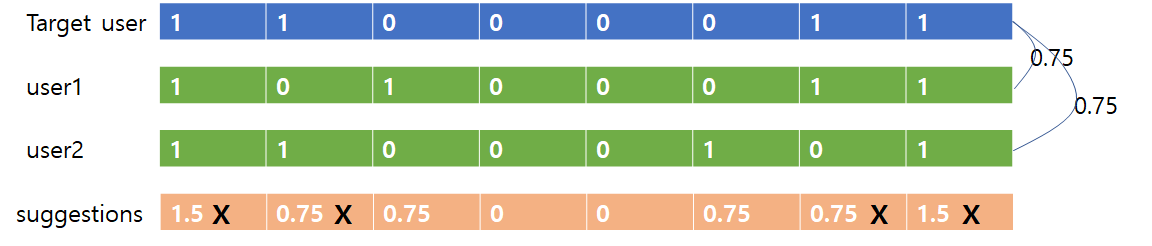

In [ ]:
from collections import defaultdict

def user_based_suggestions(user_id: int,
                           include_current_interests: bool = False):
    # Sum up the similarities.
    suggestions: Dict[str, float] = defaultdict(float)
    for other_user_id, similarity in most_similar_users_to(user_id):
        for interest in users_interests[other_user_id]:
            suggestions[interest] += similarity

    # Convert them to a sorted list.
    suggestions = sorted(suggestions.items(),
                         key=lambda pair: pair[-1],  # weight
                         reverse=True)

    # And (maybe) exclude already-interests
    if include_current_interests:
        return suggestions
    else:
        return [(suggestion, weight)
                for suggestion, weight in suggestions
                if suggestion not in users_interests[user_id]]

ubs0 = user_based_suggestions(0)
interest, score = ubs0[0]
assert interest == 'MapReduce'
assert 0.56 < score < 0.57
interest, score = ubs0[1]
assert interest == 'MongoDB'
assert 0.50 < score < 0.51

## **Item-Based Collaborative Filtering**

In [ ]:
interest_user_matrix = [[user_interest_vector[j]
                         for user_interest_vector in user_interest_vectors]
                        for j, _ in enumerate(unique_interests)]

[1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0]

interest_similarities = [[cosine_similarity(user_vector_i, user_vector_j)
                          for user_vector_j in interest_user_matrix]
                         for user_vector_i in interest_user_matrix]

def most_similar_interests_to(interest_id: int):
    similarities = interest_similarities[interest_id]
    pairs = [(unique_interests[other_interest_id], similarity)
             for other_interest_id, similarity in enumerate(similarities)
             if interest_id != other_interest_id and similarity > 0]
    return sorted(pairs,
                  key=lambda pair: pair[-1],
                  reverse=True)

msit0 = most_similar_interests_to(0)
assert msit0[0][0] == 'Hadoop'
assert 0.815 < msit0[0][1] < 0.817
assert msit0[1][0] == 'Java'
assert 0.666 < msit0[1][1] < 0.667

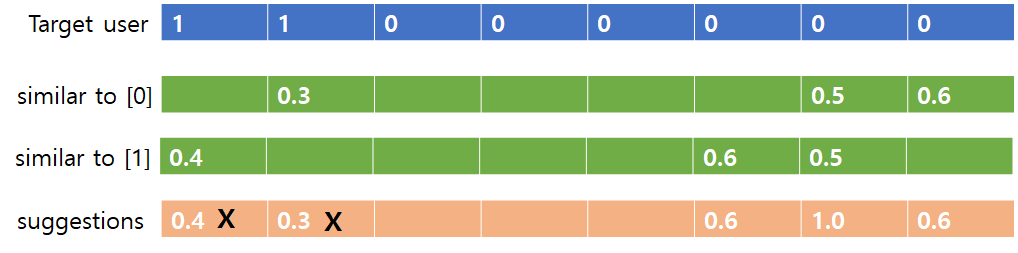

In [ ]:
def item_based_suggestions(user_id: int,
                           include_current_interests: bool = False):
    # Add up the similar interests
    suggestions = defaultdict(float)
    user_interest_vector = user_interest_vectors[user_id]
    for interest_id, is_interested in enumerate(user_interest_vector):
        if is_interested == 1:
            similar_interests = most_similar_interests_to(interest_id)
            for interest, similarity in similar_interests:
                suggestions[interest] += similarity

    # Sort them by weight
    suggestions = sorted(suggestions.items(),
                         key=lambda pair: pair[-1],
                         reverse=True)

    if include_current_interests:
        return suggestions
    else:
        return [(suggestion, weight)
                for suggestion, weight in suggestions
                if suggestion not in users_interests[user_id]]

[('MapReduce', 1.861807319565799),
 ('Postgres', 1.3164965809277263),
 ('MongoDB', 1.3164965809277263),
 ('NoSQL', 1.2844570503761732),
 ('programming languages', 0.5773502691896258),
 ('MySQL', 0.5773502691896258),
 ('Haskell', 0.5773502691896258),
 ('databases', 0.5773502691896258),
 ('neural networks', 0.4082482904638631),
 ('deep learning', 0.4082482904638631),
 ('C++', 0.4082482904638631),
 ('artificial intelligence', 0.4082482904638631),
 ('Python', 0.2886751345948129),
 ('R', 0.2886751345948129)]

ibs0 = item_based_suggestions(0)
assert ibs0[0][0] == 'MapReduce'
assert 1.86 < ibs0[0][1] < 1.87
assert ibs0[1][0] in ('Postgres', 'MongoDB')  # A tie
assert 1.31 < ibs0[1][1] < 1.32

## **Matrix Factorization**

In [ ]:
from google.colab import files
uploaded = files.upload()

import pandas as pd
import io

# You can download it from http://files.grouplens.org/datasets/movielens/ml-100k.zip.

# This points to the current directory, modify if your files are elsewhere.
MOVIES = "u.item"   # pipe-delimited: movie_id|title|...
RATINGS = "u.data"  # tab-delimited: user_id, movie_id, rating, timestamp

df_movies = pd.read_csv(io.BytesIO(uploaded[MOVIES]), delimiter='|', encoding='latin-1', header=None)
df_ratings = pd.read_csv(io.BytesIO(uploaded[RATINGS]), delimiter='\t', header=None)

Saving u.data to u (3).data
Saving u.item to u (1).item


In [ ]:
from typing import NamedTuple

class Rating(NamedTuple):
    user_id: str
    movie_id: str
    rating: float

movies = {movie[1][0]:movie[1][1] for movie in df_movies.iterrows()}

# Create a list of [Rating]
ratings = [Rating(rating[1][0], rating[1][1], float(rating[1][2])) 
           for rating in df_ratings.iterrows()]

# 1682 movies rated by 943 users
assert len(movies) == 1682
assert len(list({rating.user_id for rating in ratings})) == 943

import re

# Data structure for accumulating ratings by movie_id
star_wars_ratings = {movie_id: []
                      for movie_id, title in movies.items()
                      if re.search("Star Wars|Empire Strikes|Jedi", title)}

# Iterate over ratings, accumulating the Star Wars ones
for rating in ratings:
    if rating.movie_id in star_wars_ratings:
        star_wars_ratings[rating.movie_id].append(rating.rating)

# Compute the average rating for each movie
avg_ratings = [(sum(title_ratings) / len(title_ratings), movie_id)
                for movie_id, title_ratings in star_wars_ratings.items()]

# And then print them in order
for avg_rating, movie_id in sorted(avg_ratings, reverse=True):
    print(f"{avg_rating:.2f} {movies[movie_id]}")

import random
random.seed(0)
random.shuffle(ratings)

split1 = int(len(ratings) * 0.7)
split2 = int(len(ratings) * 0.85)

train = ratings[:split1]              # 70% of the data
validation = ratings[split1:split2]   # 15% of the data
test = ratings[split2:]               # 15% of the data

avg_rating = sum(rating.rating for rating in train) / len(train)
baseline_error = sum((rating.rating - avg_rating) ** 2
                      for rating in test) / len(test)

# This is what we hope to do better than
assert 1.26 < baseline_error < 1.27


# Embedding vectors for matrix factorization model

EMBEDDING_DIM = 2

# Find unique ids
user_ids = {rating.user_id for rating in ratings}
movie_ids = {rating.movie_id for rating in ratings}

# Then create a random vector per id
user_vectors = {user_id: random_tensor(EMBEDDING_DIM)
                for user_id in user_ids}
movie_vectors = {movie_id: random_tensor(EMBEDDING_DIM)
                  for movie_id in movie_ids}

# Training loop for matrix factorization model

from typing import List
import tqdm

def loop(dataset: List[Rating],
          learning_rate: float = None) -> None:
    with tqdm.tqdm(dataset) as t:
        loss = 0.0
        for i, rating in enumerate(t):
            movie_vector = movie_vectors[rating.movie_id]
            user_vector = user_vectors[rating.user_id]
            predicted = dot(user_vector, movie_vector)
            error = predicted - rating.rating
            loss += error ** 2

            if learning_rate is not None:
                #     predicted = m_0 * u_0 + ... + m_k * u_k
                # So each u_j enters output with coefficent m_j
                # and each m_j enters output with coefficient u_j
                user_gradient = [error * m_j for m_j in movie_vector]
                movie_gradient = [error * u_j for u_j in user_vector]

                # Take gradient steps
                for j in range(EMBEDDING_DIM):
                    user_vector[j] -= learning_rate * user_gradient[j]
                    movie_vector[j] -= learning_rate * movie_gradient[j]

            t.set_description(f"avg loss: {loss / (i + 1)}")

learning_rate = 0.05
for epoch in range(20):
    learning_rate *= 0.9
    print(epoch, learning_rate)
    loop(train, learning_rate=learning_rate)
    loop(validation)
loop(test)

4.36 Star Wars (1977)
4.20 Empire Strikes Back, The (1980)
4.01 Return of the Jedi (1983)


avg loss: 14.199722065338316:   0%|          | 51/70000 [00:00<02:19, 502.68it/s]

0 0.045000000000000005


avg loss: 1.27327590555644:   0%|          | 76/70000 [00:00<01:32, 758.97it/s] 

1 0.04050000000000001


avg loss: 1.0569326464865845:   0%|          | 50/70000 [00:00<02:20, 499.61it/s]

2 0.03645000000000001


avg loss: 0.9973334979112621:   0%|          | 60/70000 [00:00<01:58, 592.37it/s]

3 0.03280500000000001


avg loss: 0.9574956968239903:   0%|          | 78/70000 [00:00<01:29, 777.53it/s]

4 0.02952450000000001


avg loss: 1.0132313122545347: 100%|██████████| 15000/15000 [00:30<00:00, 489.65it/s]


In [ ]:
original_vectors = [vector for vector in movie_vectors.values()]
components = pca(original_vectors, 2)

ratings_by_movie = defaultdict(list)
for rating in ratings:
    ratings_by_movie[rating.movie_id].append(rating.rating)

vectors = [
    (movie_id,
      sum(ratings_by_movie[movie_id]) / len(ratings_by_movie[movie_id]),
      movies[movie_id],
      vector)
    for movie_id, vector in zip(movie_vectors.keys(),
                                transform(original_vectors, components))
]

# Print top 25 and bottom 25 by first principal component
print(sorted(vectors, key=lambda v: v[-1][0])[:25])
print(sorted(vectors, key=lambda v: v[-1][0])[-25:])

dv: 917.154: 100%|██████████| 100/100 [00:00<00:00, 121.05it/s]


[(285, 4.265432098765432, 'Secrets & Lies (1996)', [-2.4083964425103597, 0.07062894423594224]), (169, 4.466101694915254, 'Wrong Trousers, The (1993)', [-2.3969894040807933, -0.41609075211106705]), (511, 4.23121387283237, 'Lawrence of Arabia (1962)', [-2.376469019595373, -0.3846058732711223]), (694, 4.045454545454546, 'Persuasion (1995)', [-2.369510417930442, 0.14050115070135838]), (1103, 3.789473684210526, 'Trust (1990)', [-2.3566782134318562, 1.4188141989971506]), (483, 4.45679012345679, 'Casablanca (1942)', [-2.355487914445603, -0.25294262862494943]), (318, 4.466442953020135, "Schindler's List (1993)", [-2.3526448321020763, 0.3767415405672848]), (64, 4.445229681978798, 'Shawshank Redemption, The (1994)', [-2.3492602863305674, 0.012802305701592465]), (98, 4.28974358974359, 'Silence of the Lambs, The (1991)', [-2.343626544599426, -0.1506321193388147]), (23, 4.1208791208791204, 'Taxi Driver (1976)', [-2.342495489960924, -0.5763179178777522]), (923, 4.155172413793103, 'Raise the Red Lant